In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import odeint
from scipy.optimize import minimize
import math

In [365]:
state='New York'

dsp=pd.read_csv('data/population.csv')
dsp = dsp[dsp['State'] == state]  
dsp= dsp['Population'].values[:]
dsp=dsp[0]
n=int(dsp.replace(',',''))
print(n)

ds1 = pd.read_csv('data/train.csv')
ds1 = ds1[ds1['Province_State'] == state] 
#ds1.fillna(0)
ds2 = pd.read_csv('data/test_all.csv')
ds2 = ds2[ds2['Province_State'] == state]


19440500


In [366]:
#trainning data
infectious_real = ds1['Active'].values[:]
infectious_real = infectious_real[-5:]
print(infectious_real)

recov_real = ds1['Recovered'].values[:]
for i in range(len(recov_real)):
    if math.isnan(recov_real[i]):
        recov_real[i]=0
#print(recov_real)
recovered_real = ds1['Deaths'].values[:] + recov_real

recovered_real=recovered_real[-5:]
print(recovered_real)
N=np.zeros(len(infectious_real))
N.fill(n)
susceptible_real = np.subtract(N,(infectious_real + recovered_real))
#print(susceptible_real)

[324355. 324910. 325474. 326087. 326699.]
[107776. 107857. 107928. 108013. 108057.]


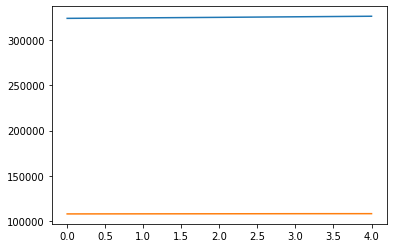

In [368]:
plt.plot(infectious_real, label='infected_real')
plt.plot(recovered_real, label='recovered_real')

In [369]:
def SIR(y,t,beta,gamma):
    S,I,R = y
    dSdt = -S*(I/(S+I+R))*beta
    dIdt = beta*S*I/(S+I+R)-gamma*I
    dRdt = gamma*I
    return [dSdt,dIdt,dRdt]

In [370]:
def loss(parameters,infectious, recovered, y0):
    size = len(infectious)
    t = np.linspace(1,size,size)
    beta, gamma = parameters
    solution = odeint(SIR, y0, t, args=(beta, gamma))
    l1 = np.mean((solution[:,1] - infectious)**2)

    l2 = np.mean((solution[:,2] - recovered)**2)

    return l1+l2

In [371]:
# initial infected 
I0 = infectious_real[0]
#print(I0)
# initial recovered(d+r) 
R0 = recovered_real[0]
print(R0)
# initial susp = N - I0 - R0
S0 = n - I0 - R0
# initialize
y0 = [S0, I0, R0]

optimal = minimize(loss,[0.0001,0.0001],
                   args=(infectious_real,recovered_real,y0),
                   method='L-BFGS-B',
                   bounds=[(0.00000001, 1), (0.00000001, 1)])
beta,gamma = optimal.x

print([beta,gamma])

107776.0
[0.0020524943673966125, 0.000227445281984205]


326699.0
26


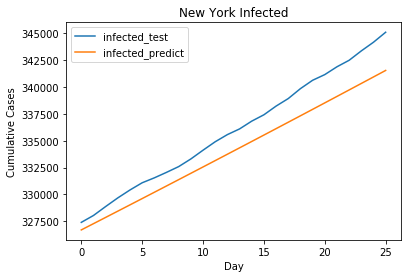

In [374]:
#beta=0.05234723060505857
#gamma=0.0014255785947061889
t = np.linspace(1,26,26)

I0_test = infectious_real[-1]
print(I0_test)
R0_test = recovered_real[-1]
S0_test = n - I0_test- R0_test
y0_test = [S0_test, I0_test, R0_test]

infectious_test = ds2['Active'].values[:]
#infectious_real = infectious_real[-50:]
#print(infectious_real)

recov_test = ds2['Recovered'].values[:]
for i in range(len(recov_test)):
    if math.isnan(recov_test[i]):
        recov_test[i]=0
#print(recov_test)
recovered_test = ds2['Deaths'].values[:] + recov_test

N=np.zeros(len(infectious_test))
N.fill(19440500)
susceptible_test = np.subtract(N,(infectious_test + recovered_test))


T = len(infectious_test)
print(T)
t = np.linspace(1,T,T)

solution = odeint(SIR, y0_test, t, args = (beta, gamma))

#print(solution)
#print(solution[:,1])
#print(solution[:,2])

plt.plot(infectious_test, label='infected_test')
plt.plot(solution[:,1], label='infected_predict')

#plt.plot(recovered_test, label='recovered_test')
#plt.plot(solution[:,2], label='recovered_predict')
plt.legend(loc='best')
plt.title(state+' Infected')
plt.xlabel('Day')
plt.ylabel('Cumulative Cases')
plt.show()

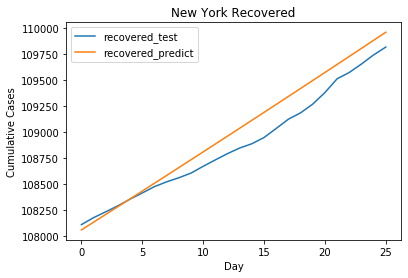

In [375]:
# 绘制估计的R曲线与真实的R曲线
plt.plot(recovered_test, label='recovered_test')
plt.plot(solution[:,2], label='recovered_predict')
plt.legend(loc='best')
plt.title(state+' Recovered')
plt.xlabel('Day')
plt.ylabel('Cumulative Cases')
plt.show()